# DÖNEM PROJESİ
# 210102002053
# ŞULE NUR DEMİRDAŞ

In [1]:
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt

In [10]:
def connected_component(binary_img):
    # Gerekli anahtar-değer çiftleri ile args sözlüğünü tanımla
    args = {"connectivity": 8}

    # Bağlantılı bileşen analizi yap
    output = cv.connectedComponentsWithStats(binary_img, args["connectivity"], cv.CV_32S)
    (numLabels, labels, stats, centroids) = output

    # Tespit edilen kişi sayısını yazdır
    print("Tespit edilen kişi sayısı:", numLabels - 1)
    return stats, centroids


In [9]:
def bounding_box(image, stats, centroids):
    image_copy = image.copy()  # Görüntünün bir kopyası ile çalış
    # Benzersiz bağlantılı bileşen etiketlerinin sayısı kadar döngüye gir
    for i in range(1, len(stats)):  # Arka planı göz ardı etmek için 1'den başla
        # Geçerli etiket için bağlantılı bileşen istatistiklerini ve merkezini al
        x = stats[i, cv.CC_STAT_LEFT]
        y = stats[i, cv.CC_STAT_TOP]
        w = stats[i, cv.CC_STAT_WIDTH]
        h = stats[i, cv.CC_STAT_HEIGHT]
        (cX, cY) = centroids[i]

        # Bağlantılı bileşeni çevreleyen bir dikdörtgen ve merkezi temsil eden bir daire çiz
        cv.rectangle(image_copy, (x, y), (x + w, y + h), (0, 255, 0), 3)
        cv.circle(image_copy, (int(cX), int(cY)), 4, (0, 0, 255), -1)

    # Görüntüyü BGR'den RGB'ye çevir (çünkü OpenCV BGR kullanır ve matplotlib RGB kullanır)
    image_copy_rgb = cv.cvtColor(image_copy, cv.COLOR_BGR2RGB)

    # Çıktı görüntüsünü matplotlib ile göster
    plt.imshow(image_copy_rgb)
    plt.axis('off')  # Eksenleri gizle
    plt.show()


In [11]:
def remove_lines(edge_map, threshold=100, minLineLength=50, maxLineGap=10):
    """
    Hough Dönüşümü kullanarak kenar haritasından çizgileri kaldırır.
    Parametreler:
    - edge_map: Giriş kenar haritası (ikili görüntü).
    - threshold: Akümülatör eşik parametresi.
    - minLineLength: Minimum çizgi uzunluğu.
    - maxLineGap: Çizgiler arasındaki maksimum boşluk.
    Döndürür:
    - cleaned_edge_map: Çizgilerin kaldırıldığı kenar haritası.
    """
    # Hough Dönüşümü kullanarak çizgileri algıla
    lines = cv.HoughLinesP(edge_map, 1, np.pi / 180, threshold=threshold, minLineLength=minLineLength, maxLineGap=maxLineGap)

    # Çizgileri kaldırmak için bir maske oluştur
    mask = np.ones(edge_map.shape, dtype=np.uint8) * 255

    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv.line(mask, (x1, y1), (x2, y2), 0, 2)

    # Maskeyi kenar haritasına uygula
    cleaned_edge_map = cv.bitwise_and(edge_map, edge_map, mask=mask)

    return cleaned_edge_map


In [4]:
def canny_edge_detection(img, low_threshold=50, ratio=3, kernel_size=3):
    """
    Basit Canny Kenar Tespiti işlemi ve matplotlib ile görselleştirme.

    Parametreler:
    - img: Gri tonlama olarak okunmuş görüntü.
    - low_threshold: Canny algoritmasının alt eşik değeri.
    - ratio: Üst eşik değerini belirlemek için kullanılan çarpan.
    - kernel_size: Gaussian Blur için kernel boyutu.
    """

    # Gürültüyü azaltmak için Gaussian Blur uygula
    img_blur = cv.GaussianBlur(img, (kernel_size, kernel_size), 0)

    # Canny Kenar Tespiti
    detected_edges = cv.Canny(img_blur, low_threshold, low_threshold * ratio, apertureSize=kernel_size)

    # Görselleştirme
    plt.figure(figsize=(10, 7))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Gri Tonlama Görüntü")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(detected_edges, cmap='gray')
    plt.title("Canny Kenar Tespiti")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return detected_edges


In [12]:
def filtering_area(stats, centroids, image_shape, min_area_ratio=0.0018, max_area_ratio=0.01):
    """
    Alan ve en boy oranına göre bağlı bileşenleri filtreler.
    Parametreler:
    - stats: Bağlı bileşen istatistikleri dizisi.
    - centroids: Bağlı bileşenlerin ağırlık merkezleri dizisi.
    - min_area_ratio: Minimum alan oranı eşiği.
    - max_area_ratio: Maksimum alan oranı eşiği.
    - image_shape: Girdi görüntüsünün boyutları.
    Dönüş:
    - filtered_stats: Filtrelenmiş bağlı bileşen istatistikleri dizisi.
    - filtered_centroids: Filtrelenmiş bağlı bileşen ağırlık merkezleri dizisi.
    """
    # Görüntünün toplam alanını hesapla
    image_area = image_shape[0] * image_shape[1]

    # Filtrelenmiş istatistikler ve ağırlık merkezlerini toplamak için boş listeler oluştur
    filtered_stats = []
    filtered_centroids = []

    for i in range(len(stats)):
        # Arka plan (label 0) için istatistikleri koru
        if i == 0:
            filtered_stats.append(stats[i])
            filtered_centroids.append(centroids[i])
            continue

        # Alan, genişlik, yükseklik ve en boy oranını al
        area = stats[i, 4]
        width = stats[i, 2]
        height = stats[i, 3]
        aspect_ratio = height / width  # En boy oranı

        # Alan oranı, en boy oranı gibi kriterlere göre filtreleme
        if (min_area_ratio < (area / image_area) < max_area_ratio) and (aspect_ratio > 1.2) and (aspect_ratio <= 4):
            filtered_stats.append(stats[i])
            filtered_centroids.append(centroids[i])

    # Listeleri numpy dizilerine dönüştür
    filtered_stats = np.array(filtered_stats)
    filtered_centroids = np.array(filtered_centroids)

    # Filtreleme sonrası tespit edilen kişi sayısını yazdır
    print("Alan filtrelemesinden sonra tespit edilen kişi sayısı:", len(filtered_stats) - 1)
    return filtered_stats, filtered_centroids


In [13]:
def remove_shadow(image):
    """
    Gölge kaldırma işlemi.
    Parametreler:
    - image: Giriş görüntüsü (grayscale).
    Dönüş:
    - shadow_free: Gölgenin kaldırıldığı görüntü.
    """
    # Fourier Dönüşümü uygula
    dft = cv.dft(np.float32(image), flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    # Yüksek geçiş filtresi oluştur
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols, 2), np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 0  # Merkez bölgesini maskele

    # Filtreyi uygula
    fshift = dft_shift * mask
    f_ishift = np.fft.ifftshift(fshift)
    image_back = cv.idft(f_ishift)  # Ters Fourier Dönüşümü
    image_back = cv.magnitude(image_back[:, :, 0], image_back[:, :, 1])

    # Normalize et
    image_back = cv.normalize(image_back, None, 0, 255, cv.NORM_MINMAX)
    image_back = np.uint8(image_back)

    return image_back


In [77]:
def main(image_path):
    # Görüntüyü gri tonlamalı olarak oku
    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    image_shape = image.shape  # Görüntü boyutunu al

    # Gölgeyi kaldır
    image_no_shadow = remove_shadow(image)

    # Yapısal eleman (5x5 dikdörtgen) oluştur, Canny eşik değeri 60 olduğunda sonuç güzel
    element_ = cv.getStructuringElement(cv.MORPH_RECT, ksize=(7,7), anchor=None)  # Yapısal elemanın boyutu ile oynamak bazı gereksiz kenarları ortadan kaldırdı

    # Kenar tespiti yap
    edges = canny_edge_detection(image_no_shadow, low_threshold=60, kernel_size=3)  # 60 eşik değeri ile Canny kenar tespiti

    # Kenar haritasından çizgileri kaldır
    cleaned_edge_map = remove_lines(edges, threshold=50, minLineLength=50, maxLineGap=20)  # 50 eşik, 50 uzunluk, 20 boşluk

    # Kenar haritasını genişlet
    dilatedImg = cv.dilate(cleaned_edge_map, element_)

    # Bağlantılı bileşen analizi yap
    stats, centroids = connected_component(dilatedImg)  # Bağlantılı bileşenlerin istatistiklerini ve merkezlerini al
    bounding_box(image, stats, centroids)  # Bağlantılı bileşenlerin etrafına dikdörtgenler çiz

    # Alan bazlı filtreleme
    filtered_stats, filtered_centroids = filtering_area(stats, centroids, image_shape, min_area_ratio=0.0022, max_area_ratio=0.02)  # Alan ve en-boy oranına göre filtrele
    bounding_box(image, filtered_stats, filtered_centroids)  # Filtrelenmiş bileşenlerin etrafına dikdörtgenler çiz

    # Sonucu görselleştir
    plt.imshow(dilatedImg, cmap='gray')  # Genişletilmiş kenar haritasını görselleştir
    plt.axis('off')  # Eksenleri gizle
    plt.show()

## TRAIN

### KOLAY - 1

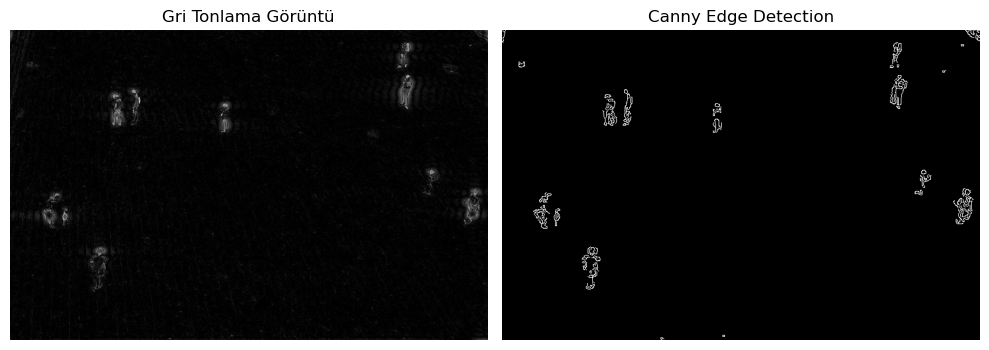

Tespit edilen kişi sayısı: 16


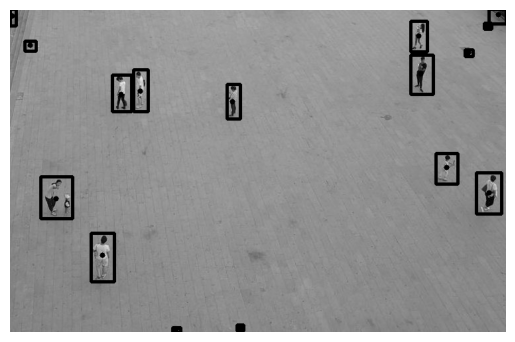

Alan filtrelemesinden sonra tespit edilen kişi sayısı: 9


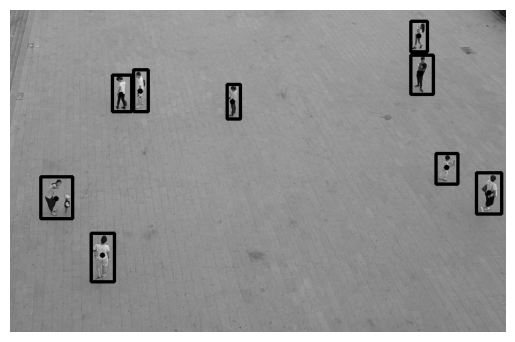

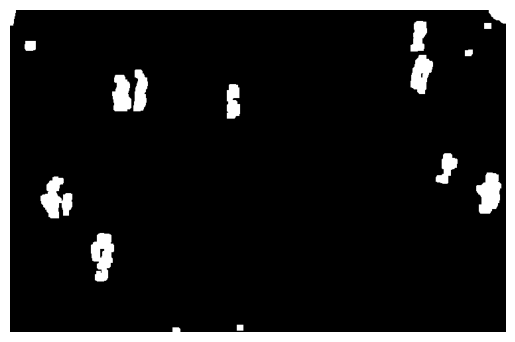

In [78]:
main("easy0.jpg")

### KOLAY - 2

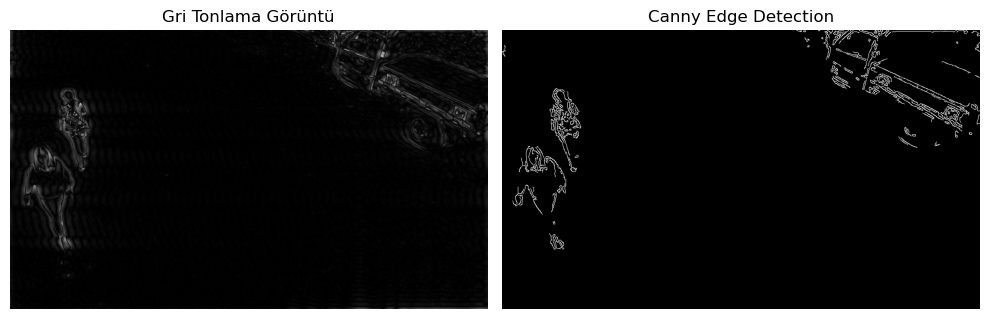

Tespit edilen kişi sayısı: 46


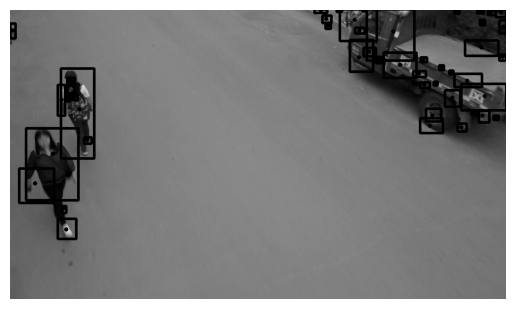

Alan filtrelemesinden sonra tespit edilen kişi sayısı: 3


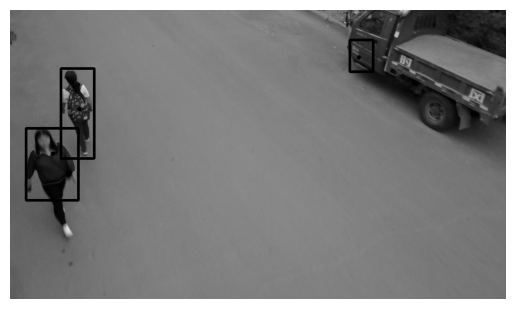

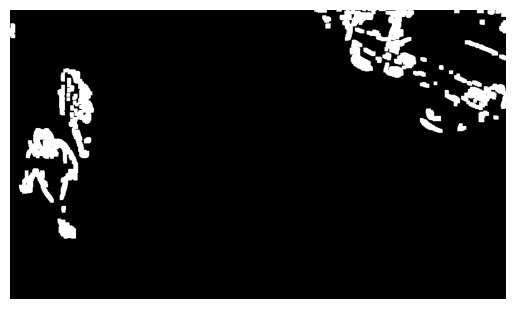

In [63]:
main("easy1_xxx.jpg")

### ORTA - 1

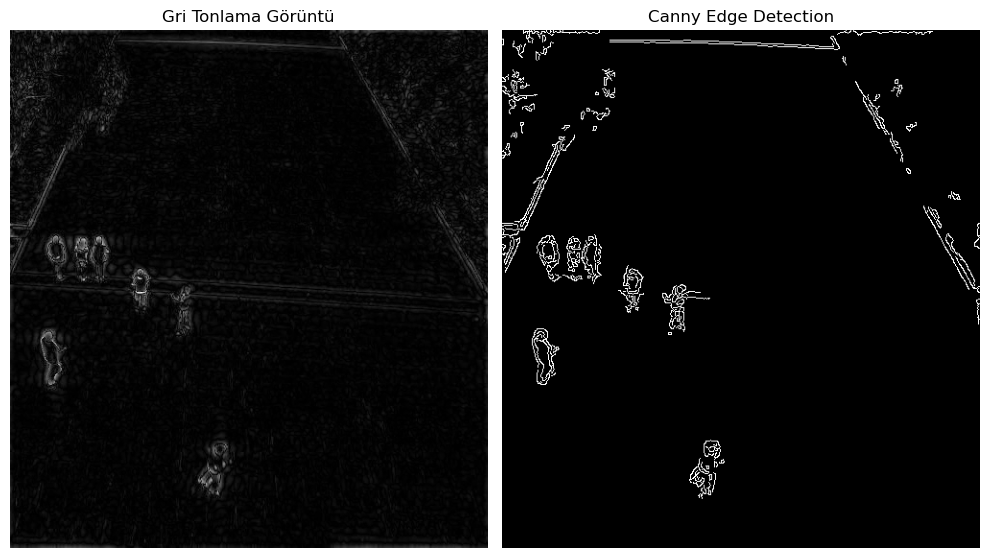

Tespit edilen kişi sayısı: 34


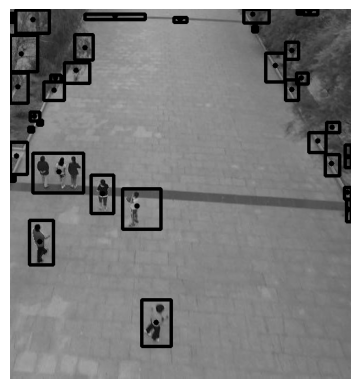

Alan filtrelemesinden sonra tespit edilen kişi sayısı: 7


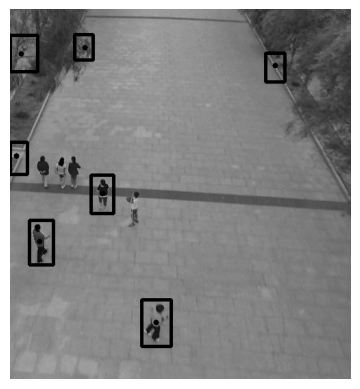

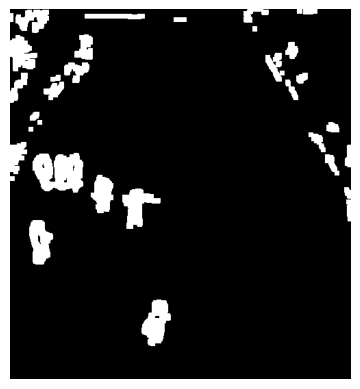

In [64]:
main("orta2_xx.jpg")

### ORTA - 2

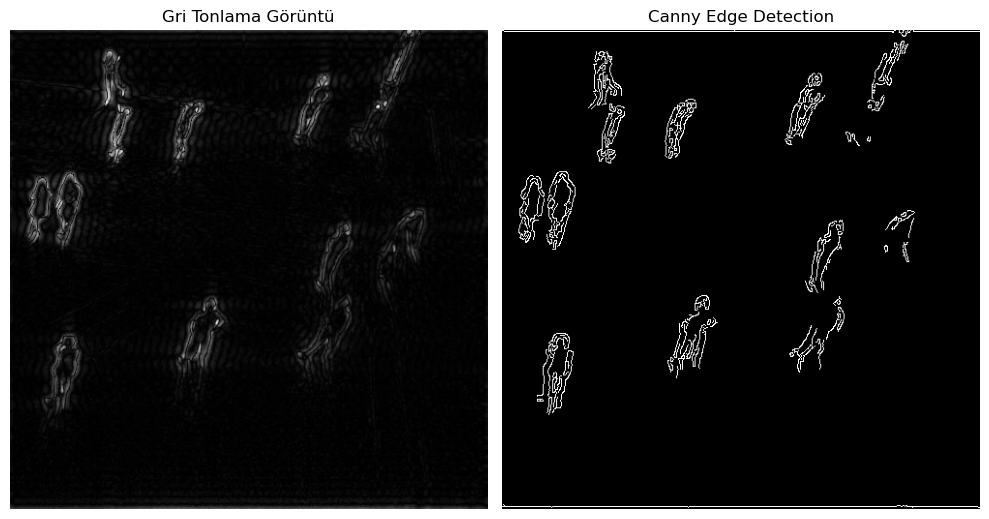

Tespit edilen kişi sayısı: 16


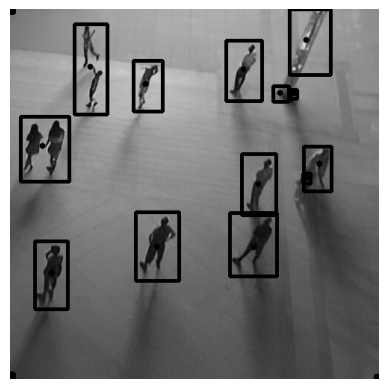

Alan filtrelemesinden sonra tespit edilen kişi sayısı: 10


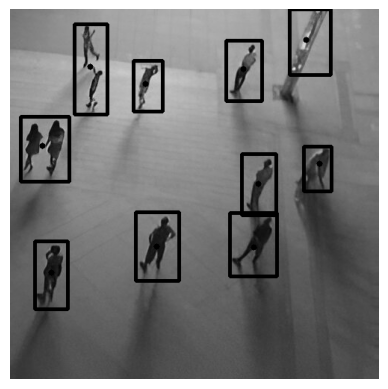

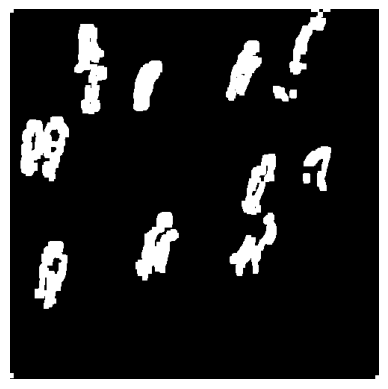

In [65]:
main("orta2_train.jpeg")

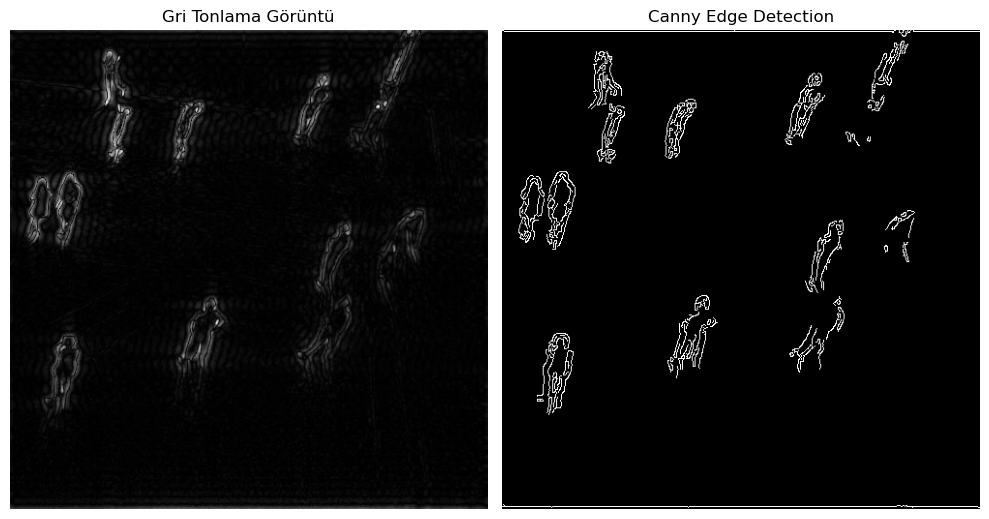

Tespit edilen kişi sayısı: 16


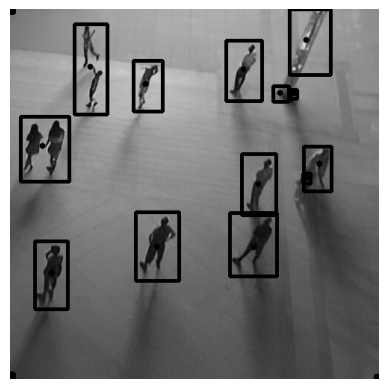

Alan filtrelemesinden sonra tespit edilen kişi sayısı: 10


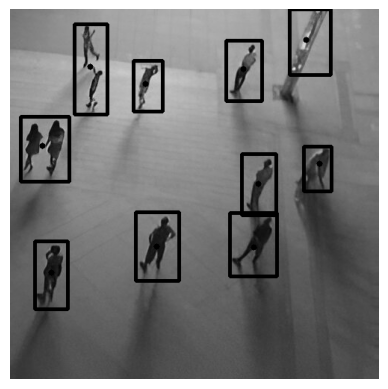

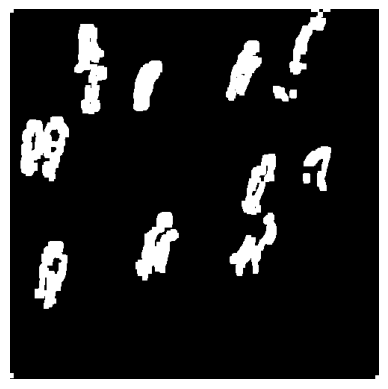

In [66]:
main("orta2_train.jpeg")

### ZOR - 1

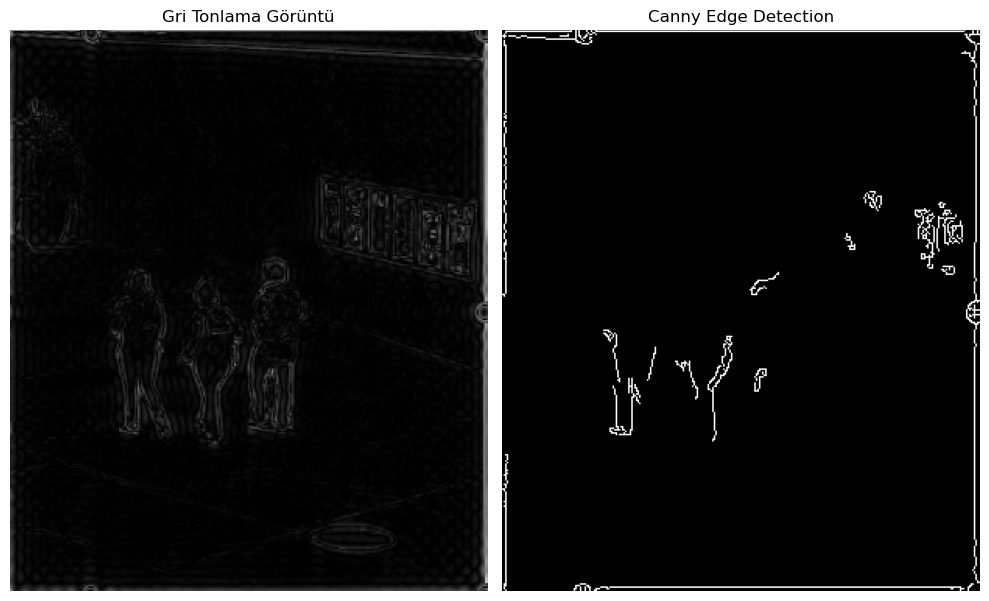

Tespit edilen kişi sayısı: 14


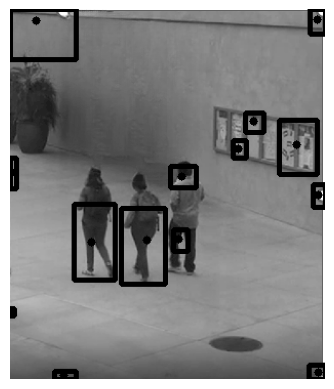

Alan filtrelemesinden sonra tespit edilen kişi sayısı: 5


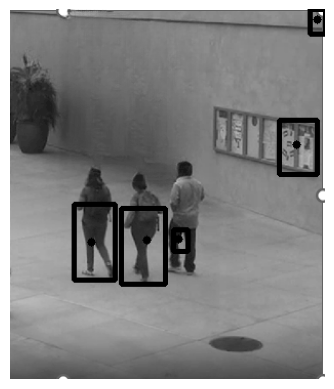

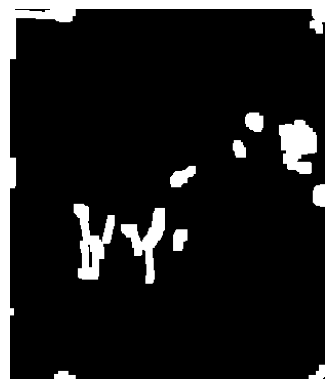

In [67]:
main("zor4__.png")

## TEST

### KOLAY

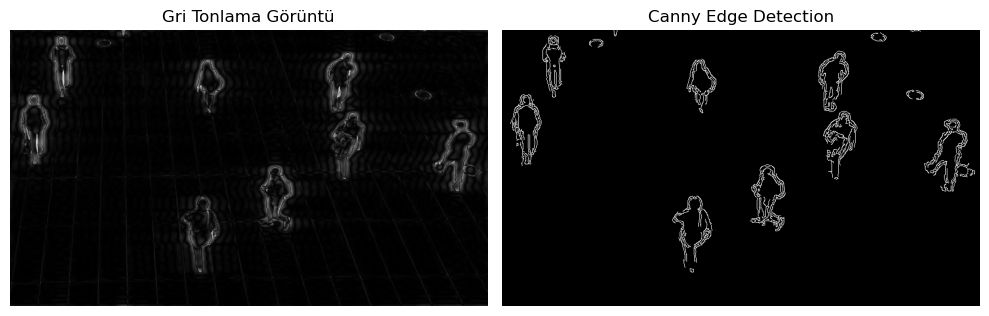

Tespit edilen kişi sayısı: 22


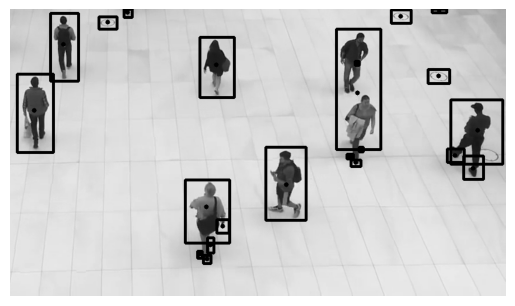

Alan filtrelemesinden sonra tespit edilen kişi sayısı: 7


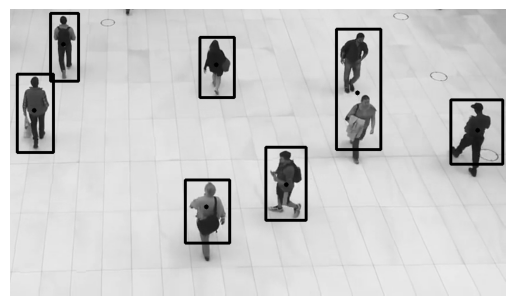

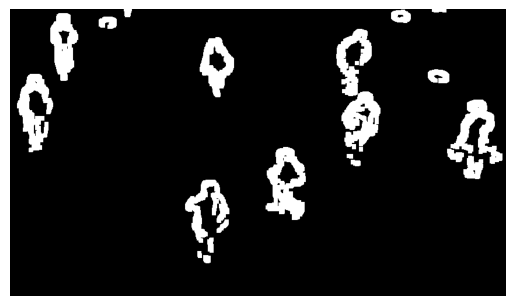

In [74]:
main("easy_test_.png")

### ORTA

### ZOR

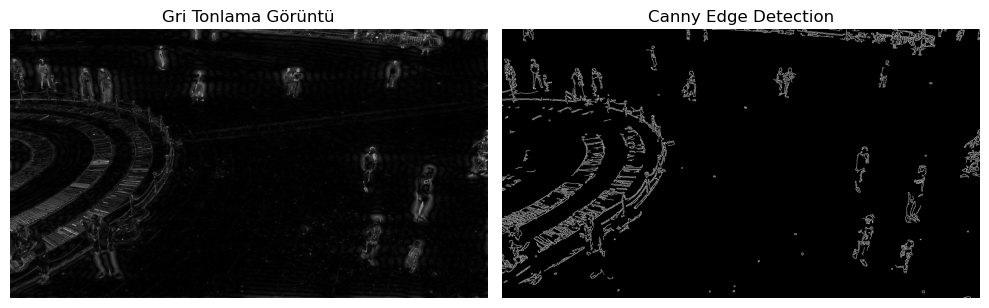

Tespit edilen kişi sayısı: 224


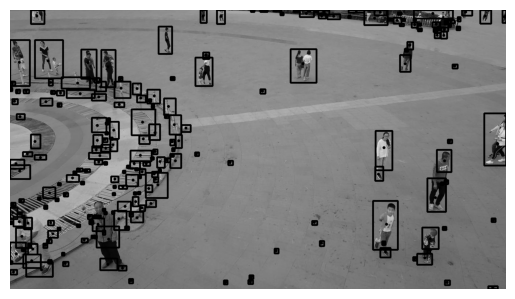

Alan filtrelemesinden sonra tespit edilen kişi sayısı: 8


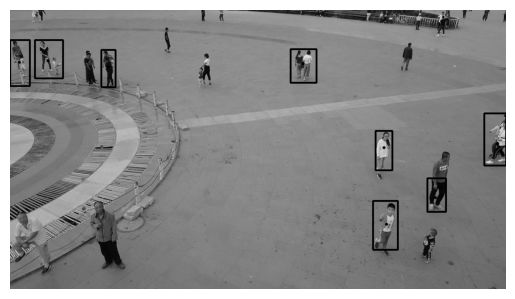

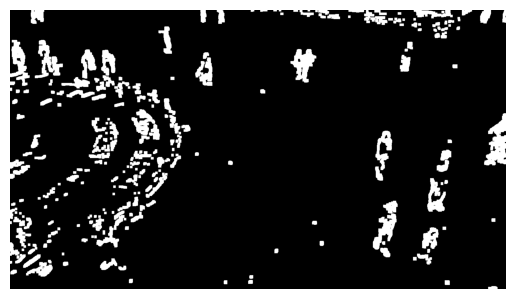

In [73]:
main("zor1_.png")

### HİÇ İNSAN İÇERMEYEN GÖRÜNTÜ

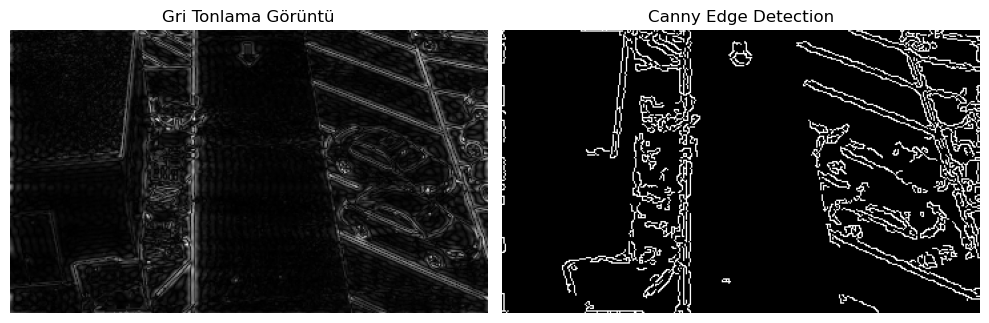

Tespit edilen kişi sayısı: 32


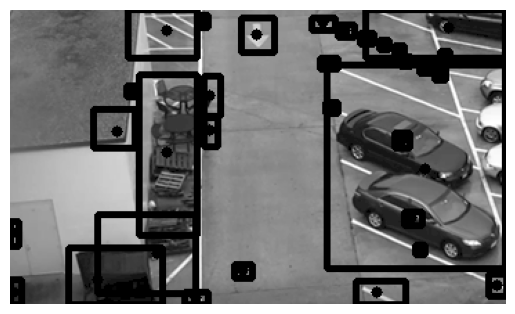

Alan filtrelemesinden sonra tespit edilen kişi sayısı: 2


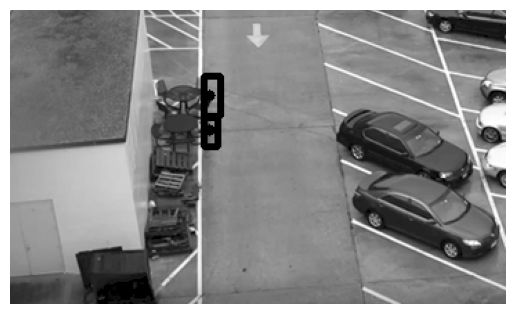

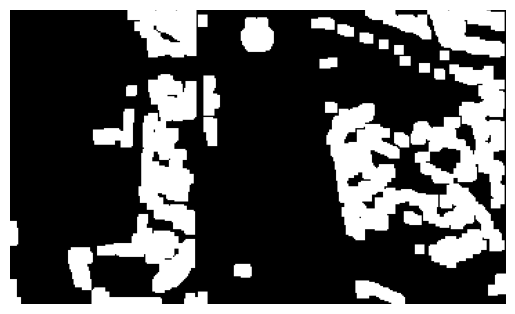

In [70]:
main("none.png")